[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# Chatbot with message summarization

## Goals

Now, let's take it one step further! 

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency. 

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langgraph-project"

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

In [5]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [9]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [10]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [11]:
from langgraph.graph import END
from typing_extensions import Literal
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than eight messages, then we summarize the conversation
    if len(messages) > 8:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

## Adding memory


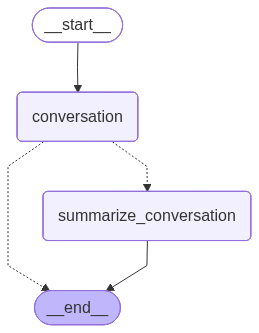

In [12]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads


In [13]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="my favourite movie is Star Wars: Revenge of the Sith")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my favourite movie?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="my close second favourite is Star Wars: The Phantom Menace")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

"Star Wars: Revenge of the Sith" is a popular choice! Released in 2005, it's the third installment in the Star Wars prequel trilogy and directed by George Lucas. The film is known for its dramatic storyline, which details the transformation of Anakin Skywalker into Darth Vader and the fall of the Jedi Order. It features intense action sequences, emotional character arcs, and significant plot developments that tie the prequels to the original trilogy. What do you like most about the movie?
================================== Ai Message ==================================

Your favorite movie is "Star Wars: Revenge of the Sith."
================================== Ai Message ==================================

"Star Wars: The Phantom Menace" is another great choice! Released in 1999, it's the first film in the Star Wars prequel trilogy. Directed by George Lucas, it introduces audiences to a young Anakin Skywal

Now, we don't yet have a summary of the state because we still have < = 8 messages.

This was set in `should_continue`. 

```
    # If there are more than eight messages, then we summarize the conversation
    if len(messages) > 8:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [14]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [15]:
input_message = HumanMessage(content="i like the character darth vader specifically, even though he's not really in either of the movies i mentioned")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Darth Vader is indeed an iconic character and a central figure in the Star Wars saga. Even though he doesn't appear as Darth Vader in "The Phantom Menace" and only transforms into him at the end of "Revenge of the Sith," his presence and the journey of Anakin Skywalker are pivotal to the storyline. His complex character arc, from a promising Jedi to a Sith Lord, adds depth to the series and makes his story compelling. What aspects of Darth Vader's character do you find most intriguing?


In [17]:
input_message = HumanMessage(content="i don't understand why some people dislike his character")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Darth Vader is a complex character, and opinions about him can vary widely. Here are a few reasons why some people might have mixed feelings about him:

1. **Tragic Transformation**: Some fans find Anakin Skywalker's transformation into Darth Vader tragic and compelling, while others may feel that his fall from grace was too abrupt or not fully justified by the events depicted in the prequels.

2. **Character Development**: While many appreciate the depth added to his character through the prequels, others might feel that the portrayal of Anakin in those films didn't align with their expectations or with the imposing figure of Darth Vader from the original trilogy.

3. **Actions and Morality**: As Darth Vader, he commits numerous dark and violent acts, which can make it difficult for some viewers to sympathize with him, despite understanding his backstory.

4. **Expectations vs. Reality**: For fans of the

In [ ]:
input_message = HumanMessage(content="i get that. what do you think of science fiction movies in general?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

In [16]:
graph.get_state(config).values.get("summary","")

''

## LangSmith

Let's review the trace!

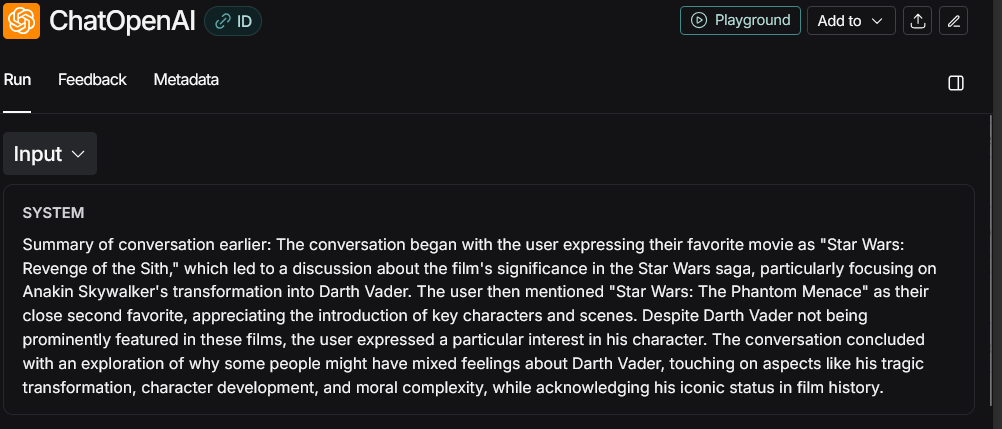

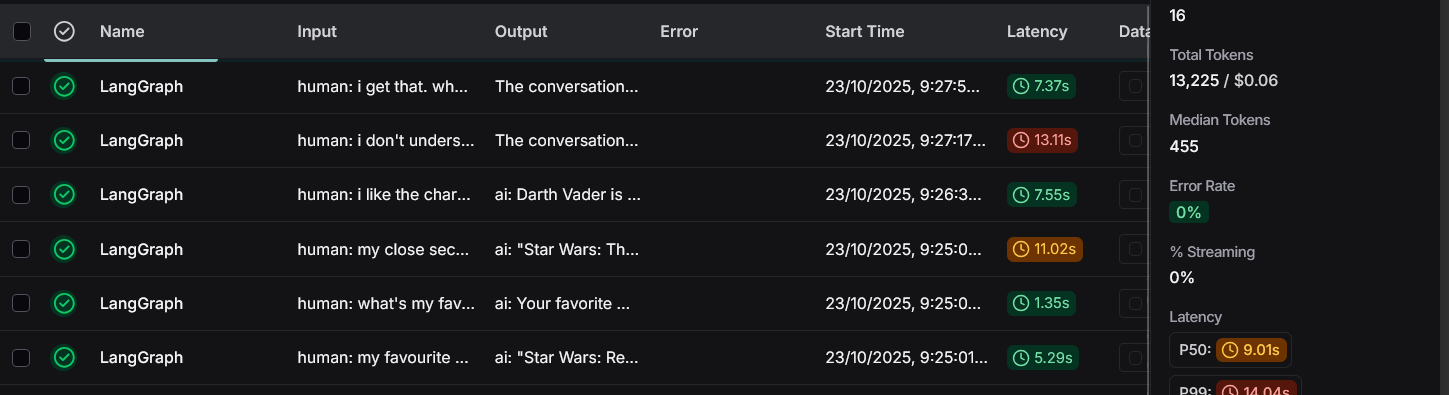